Solving H transport problem:   0%|          | 0.00/3.50k [00:00<?, ?it/s]

Solving H transport problem:   0%|          | 0.00/3.50k [00:00<?, ?it/s]

Solving H transport problem:   0%|          | 0.00/3.50k [00:00<?, ?it/s]

Solving H transport problem:   0%|          | 0.00/3.50k [00:00<?, ?it/s]

Solving H transport problem:   0%|          | 0.00/3.50k [00:00<?, ?it/s]

Solving H transport problem:   0%|          | 0.00/3.50k [00:00<?, ?it/s]

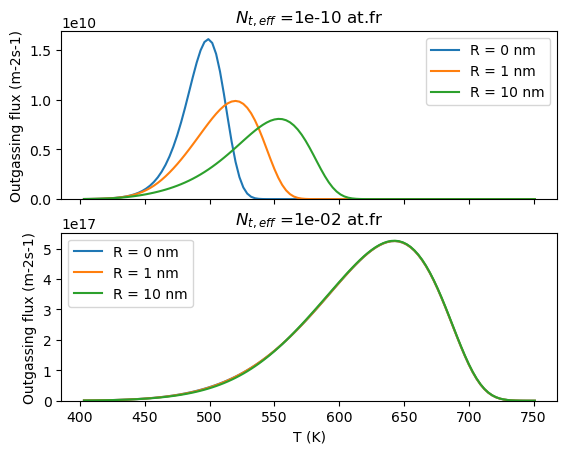

Solving H transport problem:   0%|          | 0.00/3.50k [00:00<?, ?it/s]

Solving H transport problem:   0%|          | 0.00/3.50k [00:00<?, ?it/s]

Solving H transport problem:   0%|          | 0.00/3.50k [00:00<?, ?it/s]

Solving H transport problem:   0%|          | 0.00/3.50k [00:00<?, ?it/s]

Solving H transport problem:   0%|          | 0.00/3.50k [00:00<?, ?it/s]

Solving H transport problem:   0%|          | 0.00/3.50k [00:00<?, ?it/s]

Solving H transport problem:   0%|          | 0.00/3.50k [00:00<?, ?it/s]

Solving H transport problem:   0%|          | 0.00/3.50k [00:00<?, ?it/s]

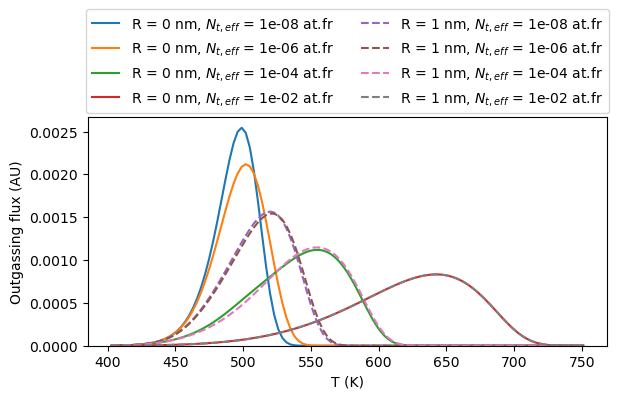

In [3]:
"""
Implementation of the cavity model from the paper:
M. Zibrov, K. Schmid,
On the factors enhancing hydrogen trapping in spherical cavities in metals,
Nuclear Materials and Energy,
Volume 38, 2024, 101617,
ISSN 2352-1791,
https://doi.org/10.1016/j.nme.2024.101617.
"""

import festim as F
from ufl import exp
import math
import numpy as np
import matplotlib.pyplot as plt


class CavityReaction(F.Reaction):
    """A reaction between mobile particles and cavity traps

    Args:
        N_t_eff (F.Species): effective trap concentration
        mobile (F.Species): mobile species
        product (F.Species): trapped species
        R (float): cavity radius (m)
        lambda_ (float): mean free path (m)
        a_m (float): surface density of mobile particles
        nu_bs (float): attempt frequency for trapping
        E_BS (float): activation energy for the bulk-to-cavity surface transition (eV)
        nu_sb (float): attempt frequency for detrapping
        E_SB (float): activation energy for the cavity surface-to-bulk transition (eV)
        D_0 (float): diffusion coefficient pre-exponential factor (m2/s)
        E_D (float): diffusion activation energy (eV)
        volume (F.VolumeSubdomain1D): the volume subdomain where the reaction takes place

    Attributes:
        N_t_eff (F.Species): effective trap concentration
        mobile (F.Species): mobile species
        R (float): cavity radius (m)
        lambda_ (float): mean free path (m)
        a_m (float): surface density of mobile particles
        nu_bs (float): attempt frequency for trapping
        E_BS (float): activation energy for the bulk-to-cavity surface transition (eV)
        nu_sb (float): attempt frequency for detrapping
        E_SB (float): activation energy for the cavity surface-to-bulk transition (eV)
        D_0 (float): diffusion coefficient pre-exponential factor (m2/s)
        E_D (float): diffusion activation energy (eV)
        volume (F.VolumeSubdomain1D): the volume subdomain where the reaction takes place

    """

    def __init__(
        self,
        N_t_eff: F.Species,
        mobile: F.Species,
        product: F.Species,
        R: float,
        lambda_: float,
        a_m: float,
        nu_bs: float,
        E_BS: float,
        nu_sb: float,
        E_SB: float,
        D_0: float,
        E_D: float,
        volume: F.VolumeSubdomain1D,
    ) -> None:
        self.N_t_eff = N_t_eff
        self.mobile = mobile
        self.R = R
        self.lambda_ = lambda_
        self.a_m = a_m
        self.E_BS = E_BS
        self.E_SB = E_SB
        self.E_D = E_D
        self.D_0 = D_0
        self.nu_bs = nu_bs
        self.nu_sb = nu_sb

        self.volume = volume

        super().__init__(
            reactant1=mobile,
            reactant2=F.ImplicitSpecies(n=0),  # ignored
            product=product,
            k_0=0,  # ignored
            E_k=0,  # ignored
            p_0=0,  # ignored
            E_p=0,  # ignored
            volume=volume,
        )

    @property
    def N_m(self):
        return self.a_m * 4 * math.pi * self.R**2

    def omega(self, c_t, temperature):
        """Eq. 20

        Args:
            c_t (dolfinx.Function): the trapped concentration
            temperature (dolfinx.Function or float): the temperature in K

        Returns:
            ufl.expression: the omega term
        """
        return 1 + self.nu_bs * self.lambda_ * self.R / self.D_0 * (
            1 - c_t / self.N_t_eff
        ) * exp((self.E_D - self.E_BS) / (F.k_B * temperature))

    def reaction_term(self, temperature):
        """
        Reaction term between mobile particles and cavity traps
        Reduced model in the case of no gradient in H potential energy landscape
        Eq. 23

        Args:
            temperature (_type_): _description_

        Returns:
            _type_: _description_
        """
        c_t = self.product.concentration
        mobile = self.mobile.concentration

        omega = self.omega(c_t=c_t, temperature=temperature)

        if self.R == 0:
            # don't have it as a function of N_m or R
            trapping_rate = (
                1
                / (6 * w_atom_density)
                * self.nu_bs
                / omega
                * exp(-self.E_BS / (F.k_B * temperature))
                * (self.N_t_eff - c_t)
                * mobile
            )
        else:
            trapping_rate = (
                4
                * math.pi
                * self.R**2
                * self.lambda_
                / self.N_m
                * self.nu_bs
                / omega
                * exp(-self.E_BS / (F.k_B * temperature))
                * (self.N_t_eff - c_t)
                * mobile
            )
        detrapping_rate = (
            self.nu_sb / omega * exp(-self.E_SB / (F.k_B * temperature)) * c_t
        )
        return trapping_rate - detrapping_rate


my_model = F.HydrogenTransportProblem()

# -------- Mesh --------- #

L = 1e-6
vertices = np.linspace(0, L, num=100)
my_model.mesh = F.Mesh1D(vertices)


# -------- Materials and subdomains --------- #

w_atom_density = 6.306e28  # atom/m3

tungsten = F.Material(D_0=1.5e-7, E_D=0.265, name="tungsten")

my_subdomain = F.VolumeSubdomain1D(id=1, borders=[0, L], material=tungsten)
left_surface = F.SurfaceSubdomain1D(id=1, x=0)
right_surface = F.SurfaceSubdomain1D(id=2, x=L)

my_model.subdomains = [
    my_subdomain,
    left_surface,
    right_surface,
]

# -------- Hydrogen species --------- #

mobile_H = F.Species("H")
trapped_H = F.Species("trapped_H", mobile=False)
my_model.species = [mobile_H, trapped_H]

# -------- Temperature --------- #

implantation_temp = 400
temperature_ramp = 0.1  # K/s
final_temp = 750


def temp_function(t):
    return implantation_temp + temperature_ramp * t


my_model.temperature = temp_function

# -------- Boundary conditions --------- #

my_model.boundary_conditions = [
    F.DirichletBC(subdomain=left_surface, value=0, species=mobile_H),
    F.DirichletBC(subdomain=right_surface, value=0, species=mobile_H),
]

# -------- Exports --------- #

left_flux = F.SurfaceFlux(field=mobile_H, surface=left_surface)
right_flux = F.SurfaceFlux(field=mobile_H, surface=right_surface)

my_model.exports = [left_flux, right_flux]

# -------- Settings --------- #

my_model.settings = F.Settings(
    atol=1e-15,
    rtol=1e-15,
    max_iterations=30,
    final_time=(final_temp - implantation_temp) / temperature_ramp,
)

my_model.settings.stepsize = F.Stepsize(initial_value=30)

# -------- Run --------- #

fig, axs = plt.subplots(2, 1, sharex=True)

for ax, N_t_eff in zip(axs, [1e-10 * w_atom_density, 1e-2 * w_atom_density]):
    plt.sca(ax)
    plt.title("$N_{t, eff}$ =" + f"{N_t_eff/w_atom_density:.0e} at.fr")
    plt.ylabel("Outgassing flux (m-2s-1)")

    for R in [0, 1e-9, 1e-8]:
        lambda_val = 1.12e-10  # m

        my_model.reactions = [
            CavityReaction(
                N_t_eff=N_t_eff,
                mobile=mobile_H,
                product=trapped_H,
                R=R,  # m
                lambda_=lambda_val,
                a_m=6 * w_atom_density * lambda_val,  # at / W * W/m3 * m = at/m2
                nu_bs=tungsten.D_0 / lambda_val**2,
                E_BS=tungsten.E_D,
                nu_sb=1e13,
                E_SB=1.5,
                E_D=tungsten.E_D,
                D_0=tungsten.D_0,
                volume=my_subdomain,
            )
        ]

        # fill the traps with hydrogen
        my_model.initial_conditions = [
            F.InitialCondition(value=N_t_eff, species=trapped_H)
        ]

        # data of derived quantities needs to be manually reset issue #728
        left_flux.data = []
        left_flux.t = []
        right_flux.data = []
        right_flux.t = []

        # initialise and run model
        my_model.initialise()
        my_model.run()

        # plot the results
        plt.plot(
            temp_function(np.array(left_flux.t)),
            np.array(left_flux.data) + np.array(right_flux.data),
            label=f"R = {R*1e9:.0f} nm",
        )
    plt.legend()
    plt.ylim(bottom=0)


plt.xlabel("T (K)")
plt.show()

# -------- Fig 3 --------- #

for R in [0, 1e-9]:

    for N_t_eff in [
        1e-8 * w_atom_density,
        1e-6 * w_atom_density,
        1e-4 * w_atom_density,
        1e-2 * w_atom_density,
    ]:

        lambda_val = 1.12e-10  # m

        my_model.reactions = [
            CavityReaction(
                N_t_eff=N_t_eff,
                mobile=mobile_H,
                product=trapped_H,
                R=R,  # m
                lambda_=lambda_val,
                a_m=6 * w_atom_density * lambda_val,  # at / W * W/m3 * m = at/m2
                nu_bs=tungsten.D_0 / lambda_val**2,
                E_BS=tungsten.E_D,
                nu_sb=1e13,
                E_SB=1.5,
                E_D=tungsten.E_D,
                D_0=tungsten.D_0,
                volume=my_subdomain,
            )
        ]

        # fill the traps with hydrogen
        my_model.initial_conditions = [
            F.InitialCondition(value=N_t_eff, species=trapped_H)
        ]

        # data of derived quantities needs to be manually reset issue #728
        left_flux.data = []
        left_flux.t = []
        right_flux.data = []
        right_flux.t = []

        # initialise and run model
        my_model.initialise()
        my_model.run()

        total_H = N_t_eff * L

        # plot the results
        if R == 0:
            linestyle = "solid"
        else:
            linestyle = "dashed"
        plt.plot(
            temp_function(np.array(left_flux.t)),
            (np.array(left_flux.data) + np.array(right_flux.data)) / total_H,
            label=f"R = {R*1e9:.0f} nm, $N_{{t, eff}}$ = {N_t_eff/w_atom_density:.0e} at.fr",
            linestyle=linestyle,
        )

plt.ylim(bottom=0)
plt.legend(ncols=2, bbox_to_anchor=(0.5, 1.5), loc="upper center")
plt.ylabel("Outgassing flux (AU)")
plt.xlabel("T (K)")
plt.tight_layout()
plt.show()